In [17]:
import pandas as pd 
import numpy as np
df=pd.read_csv("MUMBAI.csv")

/var/folders/kt/q0sjjgn94nz3_lf77pxkgr6h0000gn/T/ipykernel_2327/2495537555.py:3: DtypeWarning: Columns (12,18,19,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("MUMBAI.csv")


INDEX : Index No. of the station

MN    : Month

HR    : Hour Code

DT    : Date

SLP   : Station Level Pressure hpa

MSLP  : Mean Sea Level Pressure hpa

DBT   : Dry bulb Temperature oC

WBT   : Wet bulb Temperature oC

DPT   : Dew point Temperature oC

RH    : Relative Humidity in %, i.e. 090 means 90 %.

VP    : Vapour Pressure in hpa

DD    : Wind Direction in 16 points of compass

FFF   : Wind Speed in Km. per hour

AW    : Average Wind speed

VV    : Visibility

Cl    : Form of Low cloud 

A     : Amount of Low cloud 

Cm    : Form of Medium cloud

A.1   : Amount of Medium cloud 

Ch    : Form of High Cloud

A.2   : Amount of High cloud

Dl    : Direction of low cloud in 8 points of compass (in code)

Dm    : Direction of medium cloud in 8 points of compass (in code)

Dh    : Direction of high cloud in 8 points of compass (in code)

TC    : Total amount of cloud (in oktas)

h     : Height of low cloud

c     : Form of individual Layer of cloud

a     : Amount of individual Layer of cloud

Ht    : Height of individual Layer of cloud (in code)

RF    : Total Rainfall since previous observation in mm

EVP   : Total Evaporation in mm

DW    : Direction of Wave in 16 points of compass (in code)

P     : Period of wave (in code)

H     : Height of wave (in code)

WAT   : Water Temperature in degree C
   

In [18]:
df=df.iloc[:,:-2]
df=df.apply(pd.to_numeric,errors='coerce')

# As avg wind speed is missing for 21126 columns 
df[['AW','FFF']].corr()
# So correlation is moderate and 75% of AW data is missing let's drop it.
df.drop(["AW"], axis=1,inplace=True)

df["HR"]=df["HR"]/4

# List of categorical columns to fill by month-wise mode
cat_cols_by_month = ['DD', 'Cm', 'A.1', 'Dl', 'Dm', 'TC', 'h', 'c', 'Ht']

# Filling each categorical column's null values using the mode of its month
for col in cat_cols_by_month:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill high-null categorical columns with month-wise mode or 'Unknown'
for col in ['Ch', 'A.2', 'Dh']:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill numeric columns with median of the respective month
for col in ['VP', 'FFF', 'VV']:
    df[col] = df.groupby('MN')[col].transform(lambda x: x.fillna(x.median()))

# Fill 'DD' with mode of respective month
df['DD'] = df.groupby('MN')['DD'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna("Unknown"))

# Fill missing values with month-wise median
df['RF'] = df.groupby('MN')['RF'].transform(lambda x: x.fillna(x.median()))
# Fill by daily median first , Beacuse it may vary day to day a lot.
df['EVP'] = df.groupby(['YEAR', 'MN', 'DT'])['EVP'].transform(lambda x: x.fillna(x.median()))

# Removing INDEX and setime datetime as new Index
df=df.drop('INDEX',axis=1)
df['datetime']=pd.to_datetime(df[['YEAR','MN','DT','HR']].rename(columns={
    'YEAR':'year',
    'MN':'month',
    'DT':'day',
    'HR':'hour'
}),errors='coerce')

df.index = pd.to_datetime(df.index)
df = df[df['datetime'].dt.year != 2020]
df.set_index('datetime',inplace=True)

In [19]:
# As month,day and time don't affect fff much so drop them
df.drop(['YEAR','MN','DT','HR'],axis=1,inplace=True)

# Sorting the dataframe by timestamp
df = df.sort_values('datetime')

Outlier Detection

In [20]:
from scipy.stats import zscore
import numpy as np

# Step 1: Select numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Compute Z-scores for each numeric column
z_scores = np.abs(zscore(df[numeric_cols]))

# Step 3: Define a threshold and filter out outliers
threshold = 3
df = df[(z_scores < threshold).all(axis=1)]

In [21]:
correlation_with_fff = df.corr()['FFF'].sort_values(ascending=False)
print(correlation_with_fff)

FFF     1.000000
DD      0.805569
DBT     0.503113
WBT     0.371896
A       0.288358
Cl      0.278726
TC      0.277204
Dl      0.254787
c       0.251594
Ht      0.251594
VP      0.236208
VV      0.221812
DPT     0.216186
RF      0.208417
Dm      0.188280
Cm      0.178491
A.1     0.149542
A.2     0.001219
Ch     -0.001513
Dh     -0.004911
RH     -0.233898
EVP    -0.237352
h      -0.265520
a      -0.266727
SLP    -0.364263
MSLP   -0.366972
Name: FFF, dtype: float64


In [22]:
import numpy as np
df['VP_log'] = np.log1p(df['VP'])      
df['RF_sqrt'] = np.sqrt(df['RF'])       # for skewed rainfall

df['temp_diff'] = df['DBT'] - df['WBT']     # humidity proxy
df['humid_ratio'] = df['VP'] / (df['DBT'] + 0.1)
df['wind_humidity'] = df['RH'] * df['VV']

df['VV_squared'] = df['VV'] ** 2
df['DPT_squared'] = df['DPT'] ** 2

df['VP_roll3'] = df['VP'].rolling(window=3).mean()
df['RF_lag1'] = df['RF'].shift(1)

from scipy.stats.mstats import winsorize

df['RF_winz'] = winsorize(df['RF'], limits=[0.01, 0.01])

df['month'] = df.index.month
df['season'] = df['month'] % 12 // 3 + 1  # Season: 1=spring, ..., 4=winter

# Cyclic encode ==>> As months are in a cycle 1->12->1
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# (Optional) Drop original month column
df.drop('month', axis=1, inplace=True)

# One hot encoding ==>> COnverting categorical into Binary data
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)
df.drop('season', axis=1, inplace=True)

df.dropna(axis=0,inplace=True)
df.isnull().sum()
df.dtypes

SLP              float64
MSLP             float64
DBT              float64
WBT              float64
DPT              float64
RH                 int64
VP               float64
DD               float64
FFF              float64
VV               float64
Cl                 int64
A                  int64
Cm               float64
A.1              float64
Ch               float64
A.2              float64
Dl               float64
Dm               float64
Dh               float64
TC               float64
h                float64
c                float64
a                  int64
Ht               float64
RF               float64
EVP              float64
VP_log           float64
RF_sqrt          float64
temp_diff        float64
humid_ratio      float64
wind_humidity    float64
VV_squared       float64
DPT_squared      float64
VP_roll3         float64
RF_lag1          float64
RF_winz          float64
month_sin        float64
month_cos        float64
season_1            bool
season_2            bool


In [23]:
correlation_with_fff = df.corr()['FFF'].sort_values(ascending=False)
print(correlation_with_fff)

FFF              1.000000
DD               0.805563
DBT              0.503082
WBT              0.371856
season_3         0.318829
A                0.288327
Cl               0.278701
TC               0.277176
temp_diff        0.268573
Dl               0.254756
Ht               0.251561
c                0.251561
VP               0.236170
DPT_squared      0.235686
VP_roll3         0.235277
RF_sqrt          0.224903
VV_squared       0.221806
VV               0.221806
DPT              0.216145
RF_lag1          0.214820
VP_log           0.214292
RF_winz          0.211845
RF               0.208381
Dm               0.188260
Cm               0.178474
A.1              0.149546
season_2         0.034374
A.2              0.001219
Ch              -0.001514
Dh              -0.004912
month_sin       -0.047058
humid_ratio     -0.065695
season_1        -0.178314
season_4        -0.193495
wind_humidity   -0.232113
RH              -0.233935
EVP             -0.237316
h               -0.265488
a           

In [24]:
# Feature columns (you can fine-tune this list)
features = [
     'DD', 'DBT', 'WBT', 'A', 'temp_diff', 'Cl', 'TC', 'Dl', 'c', 'Ht',
    'DPT_squared', 'VP', 'VP_roll3', 'RF_sqrt', 'VV_squared', 'VV',
    'RF_lag1', 'DPT', 'VP_log', 'RF_winz', 'RF', 'Dm', 'Cm', 'A.1','season_1','season_2','season_3','season_4','month_sin','month_cos'
]
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# X = your features, y = your target (e.g. FFF)
X = df[features]  # your selected columns
Y = df['FFF']

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

DD             0.772277
VP_roll3       0.045990
temp_diff      0.026797
DBT            0.025460
WBT            0.013895
season_3       0.012982
VP_log         0.008638
VP             0.008501
RF_lag1        0.008400
month_cos      0.008382
DPT_squared    0.008250
TC             0.008248
DPT            0.007986
month_sin      0.007818
A              0.005571
Cl             0.004424
A.1            0.004071
season_2       0.003314
VV             0.002629
VV_squared     0.002608
RF             0.002600
RF_sqrt        0.002541
RF_winz        0.002368
Cm             0.002046
Ht             0.001233
c              0.001162
Dm             0.000799
season_4       0.000470
season_1       0.000295
Dl             0.000242
dtype: float64


WE WILL KEEP FEATURES OF importance ≥ 0.005 AND |correlation| ≥ 0.15

In [25]:
# SO NOW WILL SPLIT FEATURES INTO 3 GROUPS
primary_features=['DD', 'DBT', 'WBT', 'DPT', 'DPT_squared', 'VP_log', 'VP_roll3', 'RF_lag1',
 'VP', 'temp_diff', 'TC', 'A', 'Cl','season_3','month_sin','month_cos']
# Will try with these also and check is model performing more better or not.
secondary_features=['Dl','Ht', 'c', 'VV', 'Dm', 'Cm','season_2']


Using BiLSTM

In [26]:
# Step 1: Reshape input for BiLSTM
import numpy as np
from sklearn.model_selection import train_test_split

# X = your selected primary features
# Y = target variable (FFF)

X = df[primary_features].values
Y = df['FFF'].values

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Ensure input and output are float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')


# Reshape for LSTM: (samples, timesteps, features)
# Here, timesteps = 1 for one-step prediction
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
input_shape = (1, X_train.shape[2])
print("Input shape for BiLSTM:", X_train.shape)


Input shape for BiLSTM: (18044, 1, 16)


In [27]:
# Custom Attention Layer
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, return_sequences=True):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        else:
            return K.sum(output, axis=1)


In [28]:
# Step 2: Define BiLSTM model architecture
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_bilstm_model(input_shape, units=64, dropout_rate=0.2,learning_rate=1e-3):
    """
    Builds and returns a compiled BiLSTM model.
    Args:
        input_shape (tuple): Shape of input (timesteps, features)
        units (int): Number of LSTM units
        dropout_rate (float): Dropout rate after BiLSTM layer
    Returns:
        model (Sequential): Compiled Keras model
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=True))(inputs)
    x = Attention(return_sequences=False)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model


Using PSO

In [29]:
def pso_objective(params):
    from sklearn.metrics import mean_squared_error
    """
    Objective function for PSO. Builds and evaluates a BiLSTM model with given hyperparameters.
    params: [units, dropout, batch_size]
    """
    units = int(params[0])
    dropout = float(params[1])
    batch_size = int(params[2])

    # Build model
    model = create_bilstm_model(input_shape=(1, X_train.shape[2]), units=units, dropout_rate=dropout)
    
    # Train briefly (you can increase epochs later)
    model.fit(X_train, Y_train, epochs=10, batch_size=batch_size, verbose=0, validation_split=0.1)

    # Predict and calculate MSE
    preds = model.predict(X_test)
    mse = mean_squared_error(Y_test, preds)
    return mse

import random

class Particle:
    def __init__(self, bounds):
        self.position = [random.uniform(b[0], b[1]) for b in bounds]
        self.velocity = [random.uniform(-1, 1) for _ in bounds]
        self.best_position = list(self.position)
        self.best_score = float('inf')
        self.score = float('inf')

    def update_velocity(self, global_best, w=0.5, c1=1, c2=2):
        for i in range(len(self.velocity)):
            r1, r2 = random.random(), random.random()
            cognitive = c1 * r1 * (self.best_position[i] - self.position[i])
            social = c2 * r2 * (global_best[i] - self.position[i])
            self.velocity[i] = w * self.velocity[i] + cognitive + social

    def update_position(self, bounds):
        for i in range(len(self.position)):
            self.position[i] += self.velocity[i]
            # Clamp to bounds
            self.position[i] = max(bounds[i][0], min(bounds[i][1], self.position[i]))

# Define bounds: (min, max) for each parameter
# Format: [units, dropout, batch_size]
bounds = [
    (32, 128),    # LSTM units
    (0.1, 0.5),   # Dropout
    (16, 64)      # Batch size
]

# PSO Settings
num_particles = 5
num_iterations = 10

# Initialize swarm
swarm = [Particle(bounds) for _ in range(num_particles)]
global_best_position = None
global_best_score = float('inf')

for iter in range(num_iterations):
    print(f"\nIteration {iter+1}/{num_iterations}")
    
    for particle in swarm:
        # Evaluate current position
        score = pso_objective(particle.position)
        particle.score = score

        # Update personal best
        if score < particle.best_score:
            particle.best_score = score
            particle.best_position = list(particle.position)

        # Update global best
        if score < global_best_score:
            global_best_score = score
            global_best_position = list(particle.position)

    # Update velocities and positions
    for particle in swarm:
        particle.update_velocity(global_best_position)
        particle.update_position(bounds)


best_units = int(global_best_position[0])
best_dropout = float(global_best_position[1])
best_batch_size = int(global_best_position[2])

print(f"Best MSE so far: {global_best_score:.4f}")
print(f"Best Params → Units: {best_units}, Dropout: {best_dropout:.2f}, Batch Size: {best_batch_size}")




Iteration 1/10


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Step 3: Train the BiLSTM model
model = create_bilstm_model(input_shape=(1, X_train.shape[2]), units=best_units , dropout_rate=best_dropout,learning_rate = 0.001)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train,epochs=50,batch_size=best_batch_size,validation_split=0.1,verbose=1)

# Step 4: Make predictions
Y_pred = model.predict(X_test)

# Step 5: Evaluate
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.1712 - mae: 3.8048 - val_loss: 8.3825 - val_mae: 1.9297
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4057 - mae: 1.9399 - val_loss: 9.1992 - val_mae: 1.9513
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2228 - mae: 1.8851 - val_loss: 8.1322 - val_mae: 1.8138
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9224 - mae: 1.8323 - val_loss: 7.9748 - val_mae: 1.7713
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7626 - mae: 1.8166 - val_loss: 7.9570 - val_mae: 1.8547
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8775 - mae: 1.8122 - val_loss: 7.8753 - val_mae: 1.7677
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8736 - mae: 1.8042 - val_loss: 7.7066 - val_mae: 1.7605
Epoch 8/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7841 - mae: 1.7707 - val_loss: 7.5549 - val_mae: 1.7200
Epoch 9/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

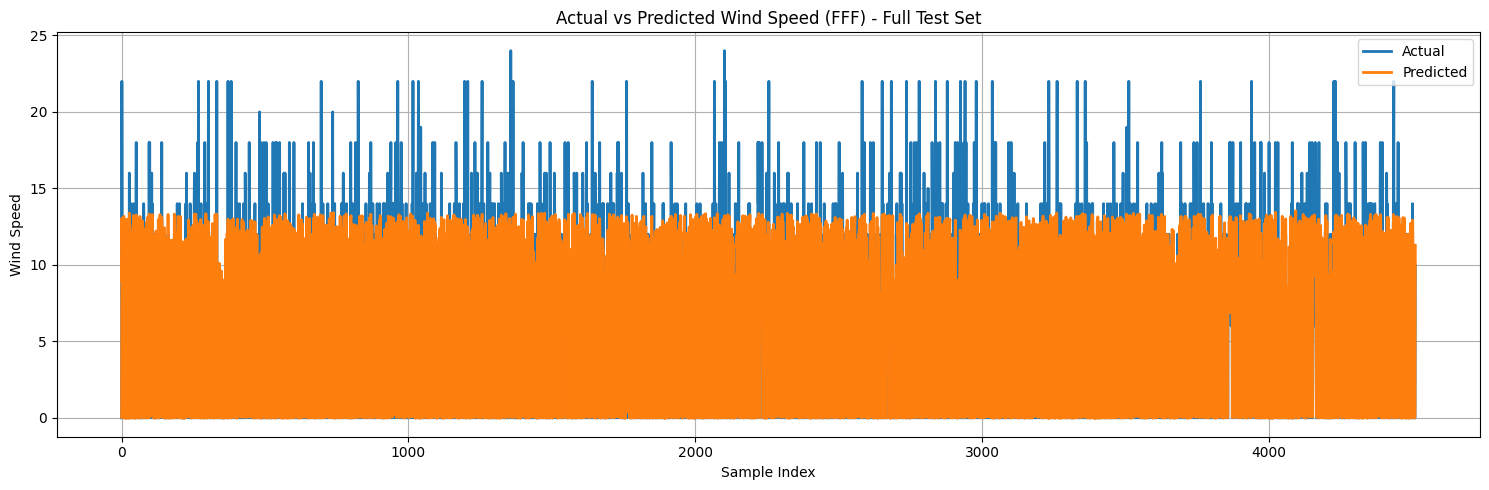

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(Y_test, label='Actual', linewidth=2)
plt.plot(Y_pred, label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Wind Speed (FFF) - Full Test Set")
plt.xlabel("Sample Index")
plt.ylabel("Wind Speed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Directory for saving plots and CSV
output_dir = "plot"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

import pandas as pd

# Replace with actual best values from your GWO
result = {
    "Timestamp": timestamp,
    "Units": best_units,
    "Dropout":best_dropout,
    "Batch Size":best_batch_size,
    "MAE": mae,
    "MSE": mse,
    "R2":r2
}

csv_path = os.path.join(output_dir, "history_bi.csv")

# Append to CSV
if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path)
    df_existing = pd.concat([df_existing, pd.DataFrame([result])], ignore_index=True)
    df_existing.to_csv(csv_path, index=False)
else:
    pd.DataFrame([result]).to_csv(csv_path, index=False)

print(f"Results appended to CSV: {csv_path}")


Results appended to CSV: plot/history_bi.csv
